**Implemented by Muhammad Hanan Asghar**

---



**Dataset** : https://www.kaggle.com/andrewmvd/pediatric-pneumonia-chest-xray

In [1]:
!nvidia-smi

Thu Jan 27 19:25:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d andrewmvd/pediatric-pneumonia-chest-xray

In [ ]:
!unzip *.zip && rm -rf *.zip

#Generators

In [84]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN = "/content/Pediatric Chest X-ray Pneumonia/train"
TEST = "/content/Pediatric Chest X-ray Pneumonia/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    TEST,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


#Libraries

In [66]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.initializers import RandomNormal

In [71]:
model = Sequential(name = "X_Ray_Detection")

model.add(Conv2D(filters=32, kernel_size=(3, 3), 
                 padding="same", 
                 input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=64, kernel_size=(3, 3), 
                 padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                 padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(rate=0.2))
model.add(Conv2D(filters=128, kernel_size=(3, 3), 
                 padding="same",
                 activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.2))

model.add(Dense(2, activation="sigmoid"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["acc"])

In [72]:
model.summary()

Model: "X_Ray_Detection"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_76 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_76 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_61 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_77 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_77 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_62 (Dropout)        (None, 32, 32, 64)    

#Callbacks

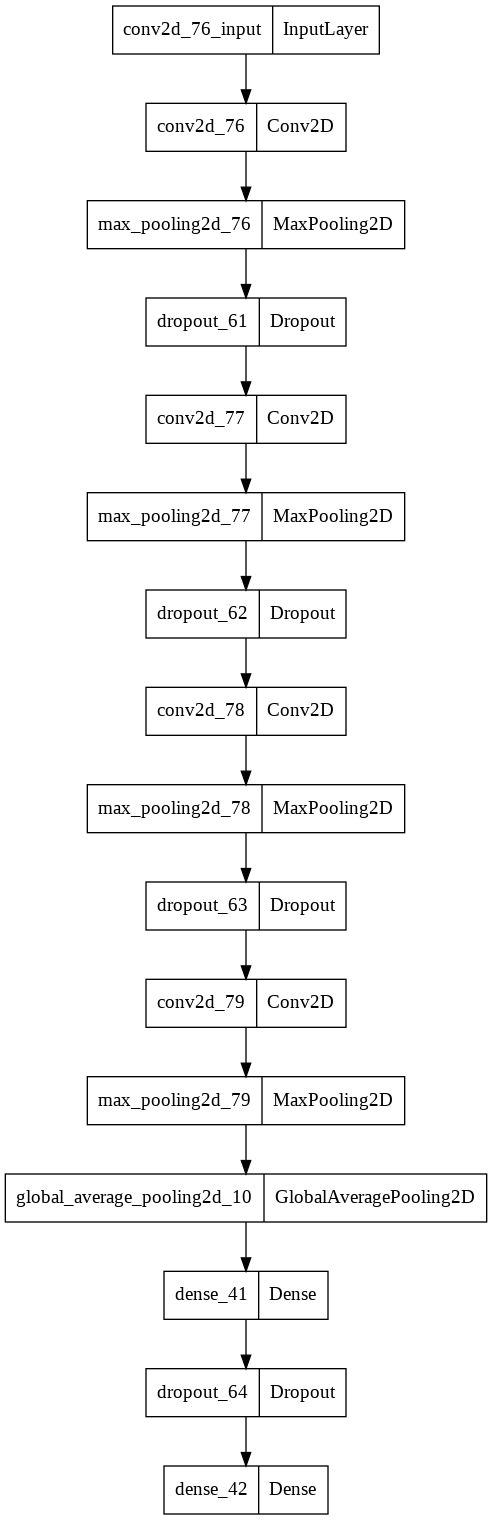

In [73]:
tf.keras.utils.plot_model(model, to_file="model.png", show_layer_names=True)

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint(
    "pneumonia_model.h5",
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

earlystop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=3,
    verbose=1,
    restore_best_weights=True
)
callbacks = [earlystop, checkpoint]

In [75]:
history = model.fit(train_generator,
  epochs = 100,
  callbacks=callbacks,
  validation_data=test_generator)

Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 0.5349 - acc: 0.7427
Epoch 00001: val_loss improved from inf to 0.62059, saving model to pneumonia_model.h5
164/164 [==============================] - 124s 751ms/step - loss: 0.5349 - acc: 0.7427 - val_loss: 0.6206 - val_acc: 0.6202
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 0.4202 - acc: 0.7884
Epoch 00002: val_loss improved from 0.62059 to 0.58335, saving model to pneumonia_model.h5
164/164 [==============================] - 123s 752ms/step - loss: 0.4202 - acc: 0.7884 - val_loss: 0.5834 - val_acc: 0.6987
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 0.3583 - acc: 0.8305
Epoch 00003: val_loss improved from 0.58335 to 0.49028, saving model to pneumonia_model.h5
164/164 [==============================] - 124s 754ms/step - loss: 0.3583 - acc: 0.8305 - val_loss: 0.4903 - val_acc: 0.7580
Epoch 4/100
164/164 [==============================] - ETA: 0s - loss: 0.3379 - 

In [76]:
model.evaluate(test_generator)

20/20 [==============================] - 6s 313ms/step - loss: 0.3675 - acc: 0.8397


[0.36749592423439026, 0.8397436141967773]

In [97]:
train_generator.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

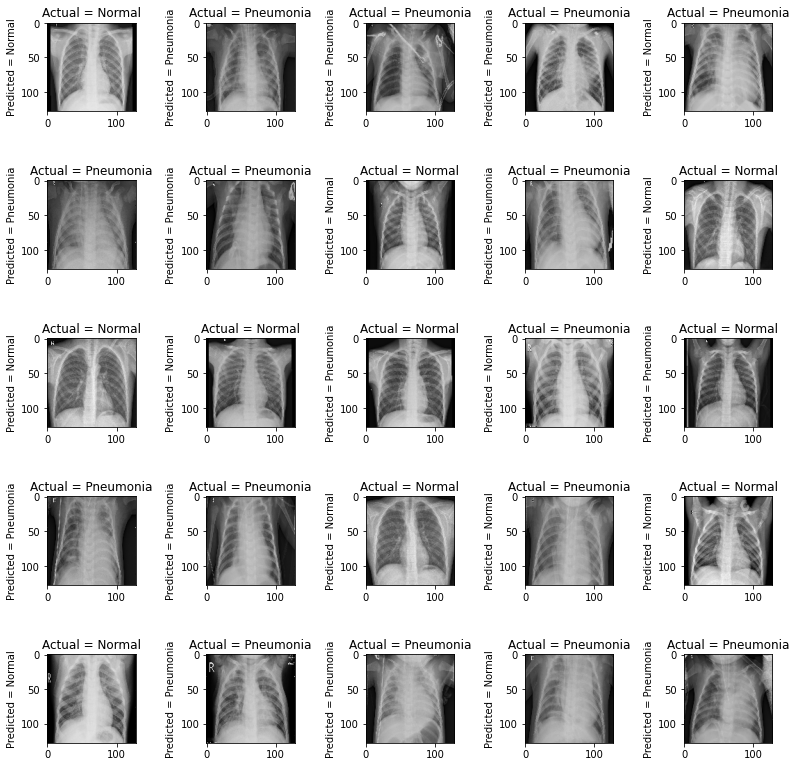

In [99]:
model_x = tf.keras.models.load_model("/content/pneumonia_model.h5")

images, labels = next(test_generator)
predictions = model_x.predict(images)

import matplotlib.pyplot as plt
import numpy as np

label_s = ['Normal', 'Pneumonia']
plt.figure(figsize=(13,13))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(images[i])
  plt.title("Actual = " + str(label_s[np.argmax(labels[i])]))
  plt.ylabel("Predicted = " + str(label_s[np.argmax(predictions[i])]))
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.35)
plt.show()

**Using Transfer Learning**

In [100]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN = "/content/Pediatric Chest X-ray Pneumonia/train"
TEST = "/content/Pediatric Chest X-ray Pneumonia/test"

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=40,
    fill_mode="nearest"
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)
test_generator = test_datagen.flow_from_directory(
    TEST,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical"
)

Found 5232 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet',
              include_top=False,
              input_shape = (224, 224, 3))

In [102]:
for layer in model.layers:
  layer.trainable = False

In [103]:
def layer_adder(bottom_model, numclasses):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(numclasses, activation='softmax')(top_model)
  return top_model

In [104]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, ZeroPadding2D, Input
from keras.models import Model


FC_Head = layer_adder(model, 2)
model = Model(inputs = model.input, outputs = FC_Head)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [105]:
model.compile(loss="categorical_crossentropy",
              optimizer='Adam',
              metrics=['accuracy'])

In [106]:
from keras.callbacks import ModelCheckpoint, EarlyStopping


checkpoint = ModelCheckpoint("vgg_pneumonia_model.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose = 1)

earlystop = EarlyStopping(monitor="val_loss",
                         min_delta=0,
                         patience=3,
                         verbose=1,
                         restore_best_weights=True)

callbacks = [earlystop, checkpoint]

In [107]:
history = model.fit(train_generator,
                    epochs = 100,
                    callbacks=callbacks,
                    validation_data=test_generator)

Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 0.2767 - accuracy: 0.8846
Epoch 00001: val_loss improved from inf to 0.45141, saving model to vgg_pneumonia_model.h5
164/164 [==============================] - 160s 881ms/step - loss: 0.2767 - accuracy: 0.8846 - val_loss: 0.4514 - val_accuracy: 0.8317
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 0.1786 - accuracy: 0.9283
Epoch 00002: val_loss improved from 0.45141 to 0.28449, saving model to vgg_pneumonia_model.h5
164/164 [==============================] - 133s 808ms/step - loss: 0.1786 - accuracy: 0.9283 - val_loss: 0.2845 - val_accuracy: 0.8910
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 0.1423 - accuracy: 0.9394
Epoch 00003: val_loss did not improve from 0.28449
164/164 [==============================] - 135s 822ms/step - loss: 0.1423 - accuracy: 0.9394 - val_loss: 0.4948 - val_accuracy: 0.8189
Epoch 4/100
164/164 [==============================] - ETA: 0s - lo

In [108]:
model.evaluate(test_generator)

20/20 [==============================] - 11s 544ms/step - loss: 0.2845 - accuracy: 0.8910


[0.2844873368740082, 0.8910256624221802]

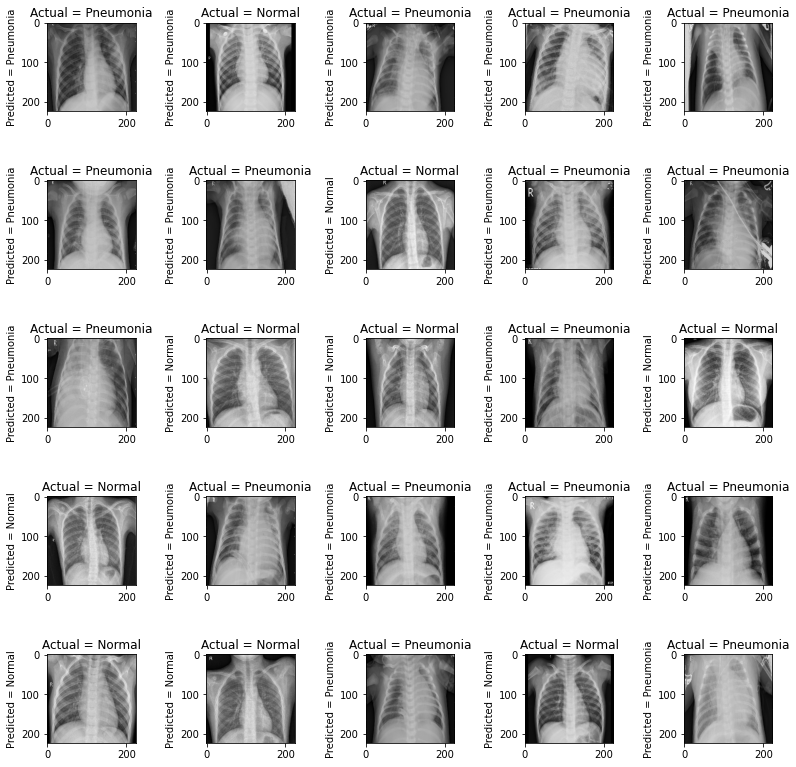

In [111]:
model_y = tf.keras.models.load_model("/content/vgg_pneumonia_model.h5")

images, labels = next(test_generator)
predictions = model_y.predict(images)

import matplotlib.pyplot as plt
import numpy as np

label_s = ['Normal', 'Pneumonia']
plt.figure(figsize=(13,13))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(images[i])
  plt.title("Actual = " + str(label_s[np.argmax(labels[i])]))
  plt.ylabel("Predicted = " + str(label_s[np.argmax(predictions[i])]))
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.35)
plt.show()

Found 624 images belonging to 2 classes.


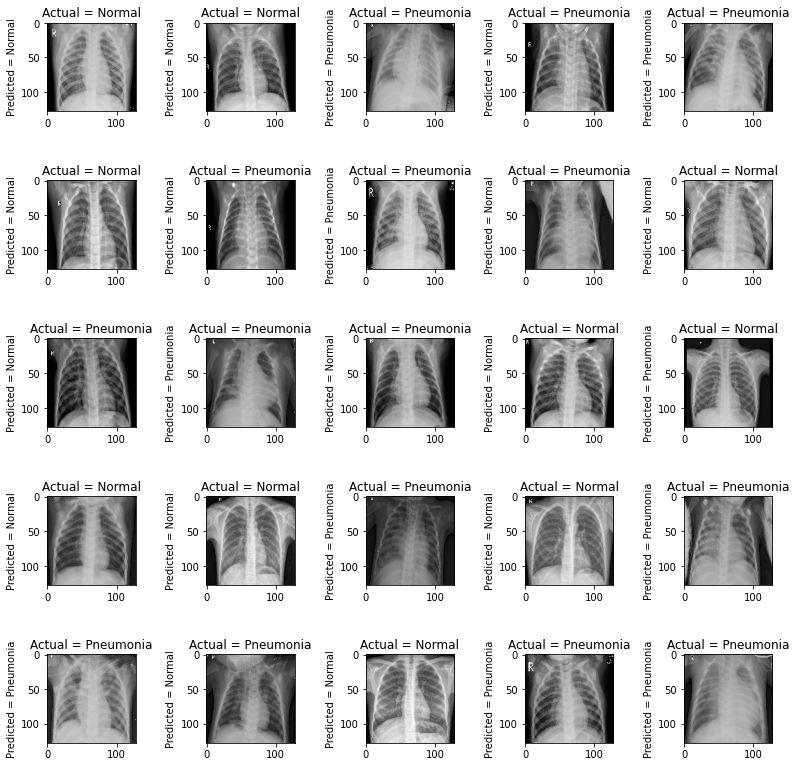

In [113]:
test_datagen = ImageDataGenerator(
    rescale=1./255
)

t_generator = test_datagen.flow_from_directory(
    TEST,
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical"
)

model_x = tf.keras.models.load_model("/content/pneumonia_model.h5")

images, labels = next(t_generator)
predictions = model_x.predict(images)

import matplotlib.pyplot as plt
import numpy as np

label_s = ['Normal', 'Pneumonia']
plt.figure(figsize=(13,13))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(images[i])
  plt.title("Actual = " + str(label_s[np.argmax(labels[i])]))
  plt.ylabel("Predicted = " + str(label_s[np.argmax(predictions[i])]))
plt.subplots_adjust(left=0.125,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.35)
plt.show()